In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.cluster import KMeans, AffinityPropagation
import matplotlib.pyplot as plt
import nltk
from nltk.metrics.distance import edit_distance
from tqdm.notebook import tqdm
import sys
import pickle
import string
import sys, math, random, copy

In [3]:
df = pd.read_csv("./drugsatfda20211116/Products.txt", sep='\t+', engine='python')
drugNames = df['DrugName']
drugNames = drugNames.drop_duplicates() \
                     .dropna()
random_incides = [np.random.randint(0, len(drugNames)) for _ in range(10)]
drugNames.iloc[random_incides]
names = np.array(drugNames)
lasa_names = np.unique(np.loadtxt("lists_LASA/sa_ISMP+FDA.txt", dtype=str))
names = np.append(lasa_names, names)
print(len(lasa_names))

164


In [5]:
# Apply thresholding so not all medications get clustered (so not everything gets clasified as LASA)
file_path = 'lev_dist_FDA_newphonetic_1000_wLASA.pickle'
# pickle.dump(lev_dist, open(file_path, "wb"))
lev_dist = pickle.load(open(file_path, "rb"))

# Distance to similarity
lev_sim = 1 / (1 + lev_dist)

# Cluster on computed similarities
aff_prop = AffinityPropagation(affinity="precomputed", damping=0.96,max_iter = 1000, verbose=True)
aff_prop.fit(lev_sim)
print(f'Found {len(aff_prop.cluster_centers_indices_)} clusters.')

C:\Users\danie\anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(


Converged after 229 iterations.
Found 158 clusters.


In [19]:
clusters = []
all_LASA = []
t=20
for cluster_id in range(len(aff_prop.cluster_centers_indices_)):
    exemplar = names[aff_prop.cluster_centers_indices_[cluster_id]]
    member_ind = np.nonzero(aff_prop.labels_ == cluster_id)
    members = names[member_ind]
    most_similar_members = set()
    # For each member (member index) of the cluster, check if it is similar enough to the rest     
    for member in member_ind[0]:
        for datapoint in range(len(lev_dist)):
            # Omit the point itself and it does not have distances below threshold, remove it, probably not LASA
            if (member != datapoint and lev_dist[member][datapoint] < t):
                most_similar_members.add(names[member])
        most_similar_members.add(exemplar)
                
    if len(most_similar_members) > 1:
        clusters.append({str(cluster_id) : most_similar_members})
        all_LASA.append(list(most_similar_members))
        print(f'\033[1m{exemplar}\033[0m ({len(most_similar_members)} most similar from {len(members)} total): {", ".join(most_similar_members)}')

DULoxetine (8 most similar from 8 total): cycloSERINE, levoFLOXacin, FLUoxetine, cloZAPine, OXYLONE, DULoxetine, OLANZapine, PARoxetine
HumuLIN (7 most similar from 7 total): PHENY-PAS-TEBAMIN, HEDULIN, ISMELIN, HumuLIN, THEELIN, SULFAMYLON, eriBULin
IDArubicin (4 most similar from 4 total): epiRUBicin, idaruCIZUmab, IDArubicin, DAUNOrubicin
LORazepam (5 most similar from 5 total): clonazePAM, ALPRAZolam, diazePAM, LORazepam, levETIRAcetam
NovoLIN (9 most similar from 9 total): KlonoPIN, LEVOleucovorin, AMINOPHYLLIN, metFORMIN, OVULEN, NovoLIN, OVULEN-21, OVULEN-28, NovoLOG
OXcarbazepine (3 most similar from 3 total): OXcarbazepine, carBAMazepine, cefTAZidime
PAZOPanib (5 most similar from 5 total): BUTAZOLIDIN, PAZOPanib, acetaZOLAMIDE, methazolAMIDE, ACYLANID
RABEprazole (5 most similar from 5 total): ARIPiprazole, metroNIDAZOLE, NEPTAZANE, RABEprazole, PRALAtrexate
SUMAtriptan (3 most similar from 3 total): SUMAtriptan, sAXagliptin, ZOLMitriptan
SUNItinib (7 most similar from 7 tota

ROBAXIN (9 most similar from 9 total): DAPTOmycin, DOXOrubicin, PROLIXIN, cloBAZam, ROBAXIN, mitoMYcin, SERPASIL, chlorproMAZINE, ROBAXIN-750
DIURIL (5 most similar from 5 total): DIAPID, HYDRODIURIL, TANDEARIL, DIURIL, CARDIOQUIN
KENACORT (6 most similar from 6 total): SANSERT, DEXACORT, PARACORT, KENACORT, ARISTOCORT, MAGNACORT
TEMARIL (6 most similar from 6 total): TACARYL, PERMITIL, PREMARIN, TEMARIL, traMADol, DEMEROL
SINOGRAFIN (4 most similar from 4 total): CARDIOGRAFIN, GASTROGRAFIN, SINOGRAFIN, CYSTOGRAFIN
ADDERALL 5 (7 most similar from 7 total): ADDERALL 30, ADDERALL 5, ADDERALL 12.5, ADDERALL 7.5, ADDERALL 10, ADDERALL 15, ADDERALL 20
KENALOG (5 most similar from 5 total): KENALOG-10, KENALOG-80, HumaLOG, KENALOG-40, KENALOG
DIUPRES-250 (3 most similar from 3 total): DIUPRES-250, MILPREM-200, DIUPRES-500
DECADRON (4 most similar from 4 total): DECADRON, DECADERM, DECADRON-LA, DECAPRYN
OPANA (15 most similar from 16 total): OPANA, PROTOPAM CHLORIDE, FOVANE, METUBINE IODIDE, 

In [15]:
# Flatten the list for easy LASA check
flat_list = [item for sublist in all_LASA for item in sublist]
print(flat_list)
print(len(flat_list))

['cycloSERINE', 'levoFLOXacin', 'FLUoxetine', 'cloZAPine', 'OXYLONE', 'DULoxetine', 'OLANZapine', 'PARoxetine', 'PHENY-PAS-TEBAMIN', 'HEDULIN', 'ISMELIN', 'HumuLIN', 'THEELIN', 'SULFAMYLON', 'eriBULin', 'epiRUBicin', 'idaruCIZUmab', 'IDArubicin', 'DAUNOrubicin', 'clonazePAM', 'ALPRAZolam', 'diazePAM', 'LORazepam', 'levETIRAcetam', 'KlonoPIN', 'LEVOleucovorin', 'AMINOPHYLLIN', 'metFORMIN', 'OVULEN', 'NovoLIN', 'OVULEN-21', 'OVULEN-28', 'NovoLOG', 'OXcarbazepine', 'carBAMazepine', 'cefTAZidime', 'BUTAZOLIDIN', 'PAZOPanib', 'acetaZOLAMIDE', 'methazolAMIDE', 'ACYLANID', 'ARIPiprazole', 'metroNIDAZOLE', 'NEPTAZANE', 'RABEprazole', 'PRALAtrexate', 'SUMAtriptan', 'sAXagliptin', 'ZOLMitriptan', 'UNITENSEN', 'PONATinib', 'CEDILANID-D', 'tiZANidine', 'SORAfenib', 'METIMYD', 'SUNItinib', 'TEGretol', 'TEGRETOL', 'TINDAL', 'DYRENIUM', 'TRANCOPAL', 'PRANTAL', 'TRANMEP', 'SERENTIL', 'TRENtal', 'fluPHENAZine', 'PHENURONE', 'PANHEPRIN', 'EPINEPHrine', 'HYDREA', 'METHERGINE', 'ePHEDrine', 'SUFentanil', 

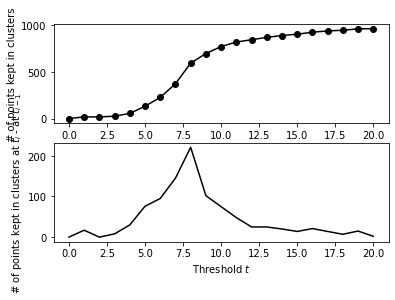

In [8]:
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
y = [0, 17, 17, 25, 55, 131, 226, 371, 592, 694, 769, 817, 842, 867, 887, 901, 922, 936, 943, 958, 960]

z = [y[i]-y[i-1] if i > 0 else 0 for i in range( len(y))]

fig, axs = plt.subplots(2)
axs[0].plot(x, y, marker="o", color="black")
axs[1].plot(x, z, color="black")
plt.setp(axs, xlabel=r"Threshold $t$")
plt.setp(axs[0], ylabel="# of points kept in clusters")
plt.setp(axs[1], ylabel="# of points kept in clusters at $t_i$ - at $t_{i-1}$")
plt.show()